In [1]:
# Some imports

# computation stuff
import torch
import numpy as np

# plotting stuff
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina' # makes the quality higher

import seaborn as sns
sns.set_style("whitegrid") # improves the quality of matplotlib images and adds grid

In [2]:
from torch import nn

In [3]:
class MyModel(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        # initialize everything from the root class
        # PyTorch won't allow you to define variable using nn.LayerName before this call
        super().__init__()

        self.net1 = nn.Linear(input_size, hidden_size)
        self.net2 = nn.ReLU()
        self.net3 = nn.Linear(hidden_size, hidden_size)
        self.net4 = nn.ReLU()
        self.net5 = nn.Linear(hidden_size, output_size)
        
    def forward(self, input_data):
        x = self.net1(input_data)
        x = self.net2(x)
        x = self.net3(x)
        x = self.net4(x)
        output = self.net5(x)
        return output

In [4]:
model = MyModel(10, 128, 2)
print(model)

MyModel(
  (net1): Linear(in_features=10, out_features=128, bias=True)
  (net2): ReLU()
  (net3): Linear(in_features=128, out_features=128, bias=True)
  (net4): ReLU()
  (net5): Linear(in_features=128, out_features=2, bias=True)
)


In [5]:
example_tensor = torch.randn(10)
model(example_tensor) # equivalent to model.forward(example_tensor)

tensor([ 0.0043, -0.0568], grad_fn=<ViewBackward0>)

In [6]:
class MyModelSequential(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()      

        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, input_data):
        return self.net(input_data) # sequential saved us a lot of space

model = MyModelSequential(10, 128, 2)
print(model)

MyModelSequential(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [7]:
model(example_tensor)

tensor([ 0.1137, -0.1815], grad_fn=<ViewBackward0>)

In [8]:
class MyCustomLayer(nn.Module):
    
    def __init__(self, in_hidden, out_hidden):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_hidden, out_hidden),
            nn.ReLU()
        )

    def forward(self, input_data):
        return self.layer(input_data)


class MyModelCustomLayer(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()      

        self.net = nn.Sequential(
            MyCustomLayer(input_size, hidden_size),
            MyCustomLayer(hidden_size, hidden_size),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, input_data):
        return self.net(input_data)

model = MyModelCustomLayer(10, 128, 2)
print(model)

MyModelCustomLayer(
  (net): Sequential(
    (0): MyCustomLayer(
      (layer): Sequential(
        (0): Linear(in_features=10, out_features=128, bias=True)
        (1): ReLU()
      )
    )
    (1): MyCustomLayer(
      (layer): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
      )
    )
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [9]:
model(example_tensor)

tensor([-0.1294, -0.1290], grad_fn=<ViewBackward0>)

model weights are initialized randomly:

In [10]:
model = MyModel(10, 128, 2)
print(model(example_tensor))

model = MyModel(10, 128, 2)
print(model(example_tensor))

tensor([ 0.0239, -0.1036], grad_fn=<ViewBackward0>)
tensor([0.0419, 0.0677], grad_fn=<ViewBackward0>)


Even though we used the same input, the result is different (this is also the reason why three equivalent versions of our model resulted in different outputs). Do not forget about randomness if you want to make your results reproducible. We will talk more about this in the next seminar

Usually PyTorch initialization scheme is enough. Sometimes you may want to do custom initialization, we won't cover how do it in details during this seminar. However, never use constant initialization, unless you know what you are doing, because this may ruin utilization of neuron difference within the layer.

# Optimization (Training a model, finding local minima, etc.)

In [11]:
def func(x):
    return (x - 10) ** 2 + 14

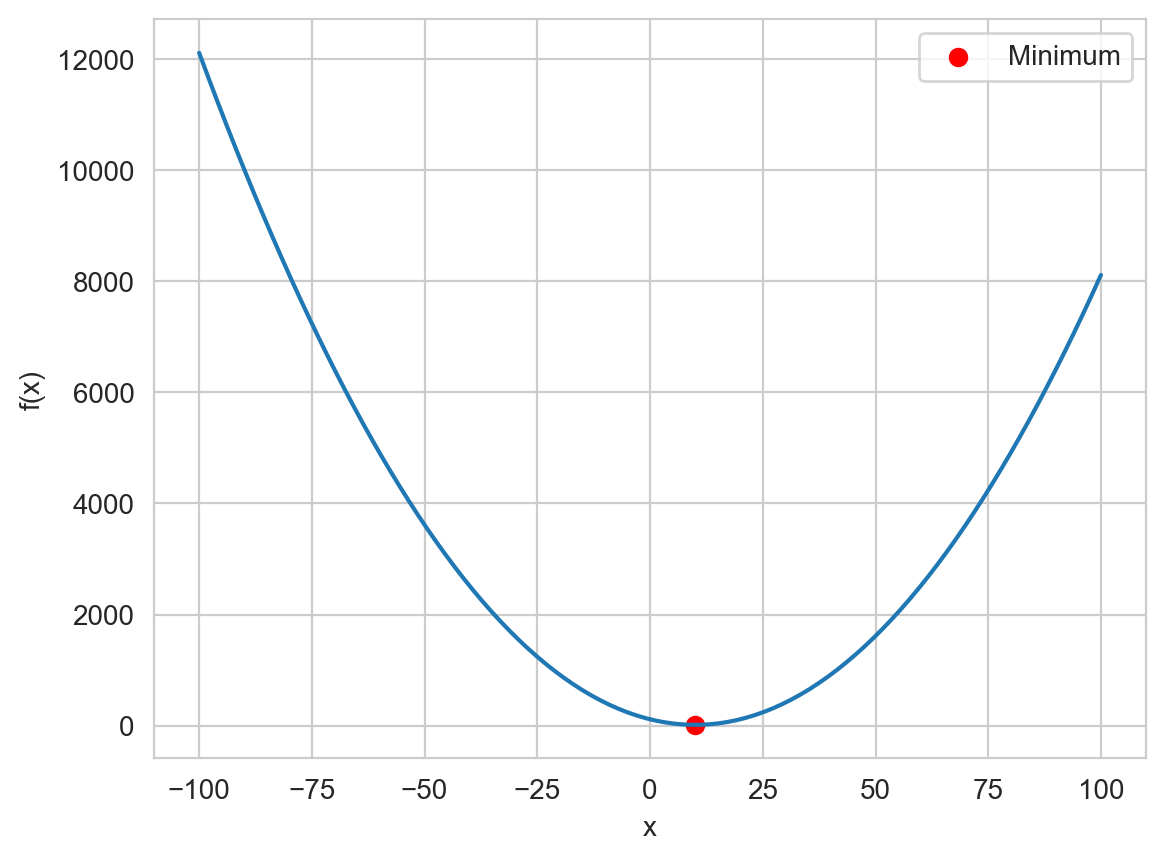

In [12]:
x = torch.linspace(-100, 100, 100)
y = func(x)

plt.plot(x, y)
plt.scatter([10], [14], label='Minimum', c='red')
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

In [13]:
import time
from IPython import display

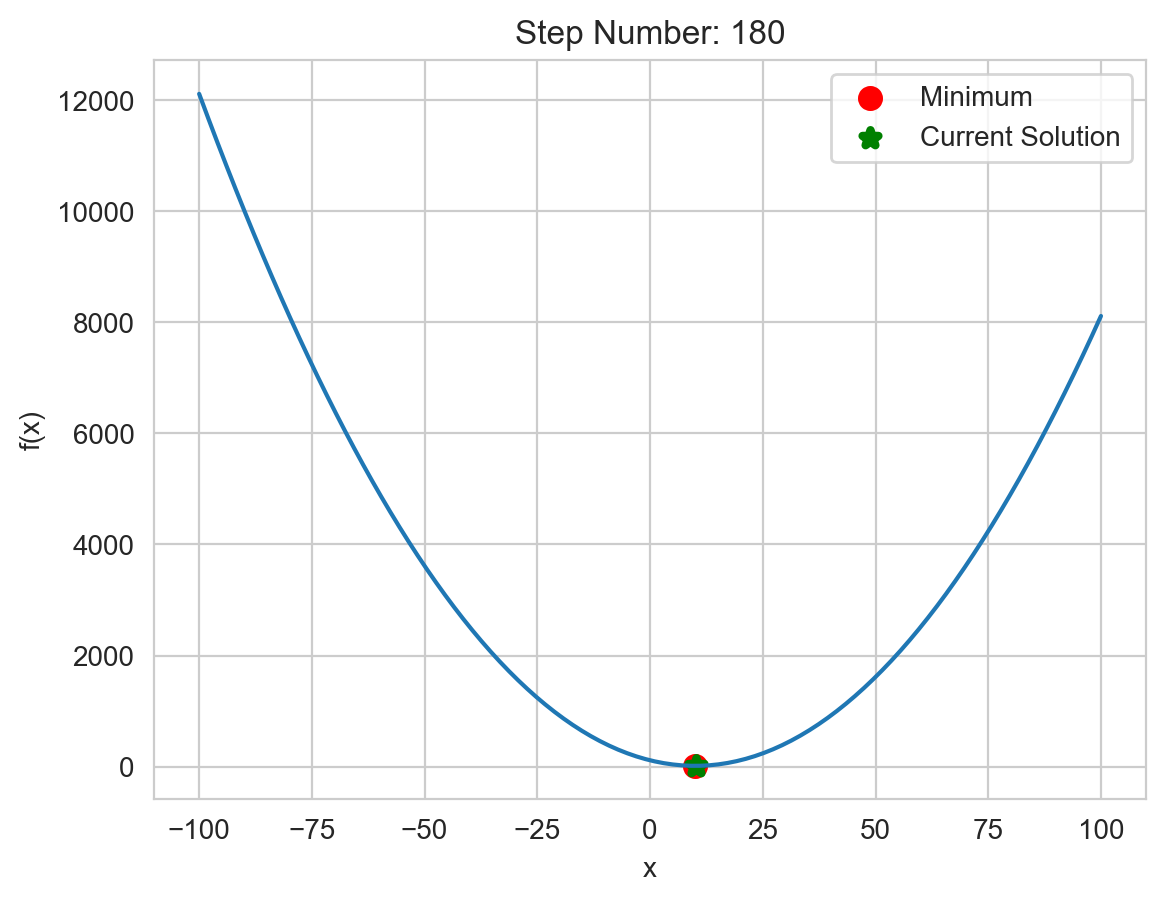

In [14]:
# requires_grad=True is required
# this is our starting point
current_solution = torch.randint(low=-100, high=100, size=(1,), dtype=torch.float32, requires_grad=True)

# initialize a simple SGD
# SGD will minimize only one variable — current_solution
optimizer = torch.optim.SGD([current_solution], lr=1e-2)

NUM_STEP = 200


for i in range(NUM_STEP):
    current_loss = func(current_solution)
    
    # zero out .grad of `current_solution` 
    # remember that otherwise your new gradients will be summed with the existing ones
    optimizer.zero_grad()
    
    # compute new gradient by `current_solution`
    current_loss.backward()
    
    # update current_solution
    optimizer.step()

    # some logging and visualization stuff
    if i % 20 == 0:
        display.clear_output()
        
        x = torch.linspace(-100, 100, 100)
        y = func(x)

        plt.plot(x, y)
        plt.scatter([10], [14], label="Minimum", c="red", linewidths=3)
        plt.scatter([current_solution.item()], [current_loss.item()],
                    label="Current Solution", marker="*", c="green", linewidths=3)
        
        plt.legend()
        plt.title(f"Step Number: {i}")
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.show()
        
        time.sleep(1)

In [15]:
from torch.utils.data import DataLoader, Dataset

In [16]:
class SimpleDataset(Dataset):
    
    def __init__(self, data: torch.Tensor, transform=None):
        self.data = data
        self.transform=transform
    
    def __getitem__(self, index: int):
        x =  self.data[index]
          
        # you can use class method
        x = self.preprocess(x)

        # or you can use transform (or both)
        if self.transform is not None:
            x = self.transform(x)
        
        return x

    def preprocess(self, x):
        # example
        return x - 300

    def __len__(self):
        return len(self.data)

In [17]:
example_data = torch.randn(1000, 10) # X = 1000 elements (vectors) of size 10
simple_dataset = SimpleDataset(example_data)
simple_dataset[0]

tensor([-301.1630, -299.4881, -299.2014, -300.3979, -299.7837, -299.7716,
        -299.8643, -300.0085, -302.0215, -301.1509])

In [18]:
def double_the_value(x):
    return 2 * x

transform = double_the_value

simple_dataset = SimpleDataset(example_data, transform=transform)
simple_dataset[0]

tensor([-602.3260, -598.9763, -598.4028, -600.7958, -599.5674, -599.5432,
        -599.7286, -600.0170, -604.0430, -602.3018])

## Mnist

In [21]:
import torchvision

In [22]:
transform = torchvision.transforms.Compose( # Sequential application of transforms, for this example it is unnecessarily
    [
        torchvision.transforms.ToTensor(), # from Image class to Tensor
    ]
)

In [23]:
mnist_train = torchvision.datasets.MNIST(
    "./mnist/", train=True, download=True, transform=transform
)
mnist_val = torchvision.datasets.MNIST(
    "./mnist/", train=False, download=True, transform=transform
)

100.0%
100.0%
100.0%
100.0%


torch.Size([1, 28, 28])


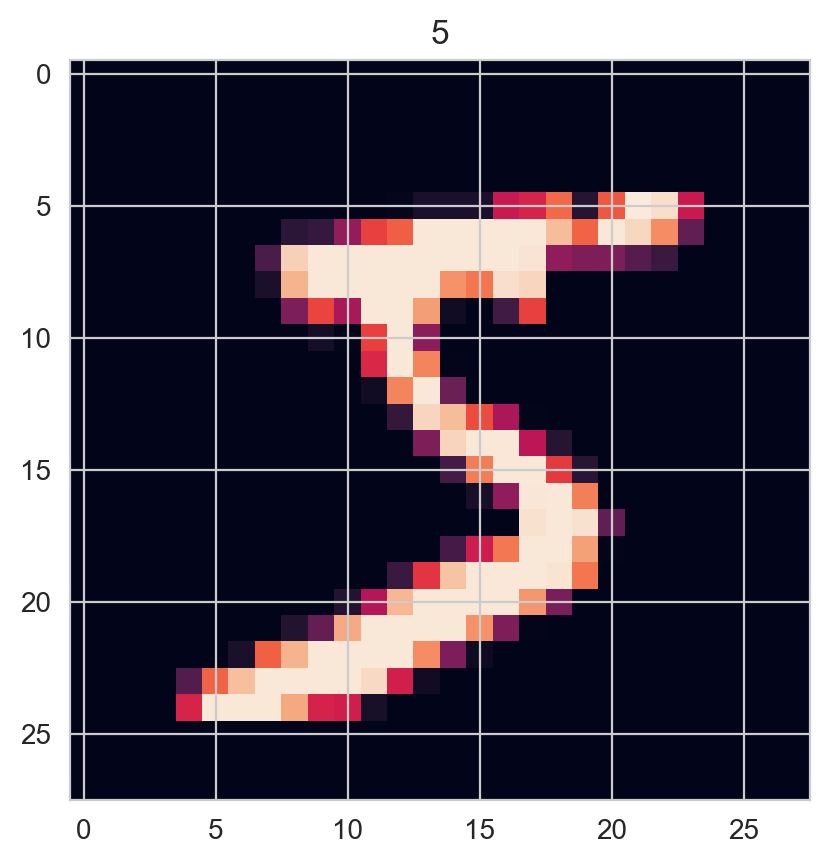

In [24]:
example_img, example_label = mnist_train[0]
print(example_img.shape) # C x H x W, 1 channel -- grayscale image
plt.imshow(example_img[0])
plt.title(example_label)
plt.show()

In [25]:
train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=128, shuffle=False)

In [26]:
print("Train Dataloader length:", len(train_dataloader))
print("Train Dataset length:", len(mnist_train))
print(len(mnist_train) // 128) # != len(train_dataloader) because drop_last=False
print(len(mnist_train) % 128) # there will be one batch of such size instead of 128

Train Dataloader length: 469
Train Dataset length: 60000
468
96


1) Fully connected (MLP)
2) CNN
3) CNN with ResBlocks

In [27]:
class FCNetwork(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()      

        self.net = nn.Sequential(
            nn.Flatten(), # reshape input from C x H x W to 1D-vector
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, input_data):
        return self.net(input_data)

In [28]:
class ConvNetwork(nn.Module):
    
    def __init__(self, input_channels, hidden_channels, output_size, image_sizes):
        super().__init__()      

        self.net = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(), # to do classification we flatten
            # you need to calculate the flatten size
            nn.Linear(hidden_channels * image_sizes[0] * image_sizes[1], output_size),
        )

    def forward(self, input_data):
        return self.net(input_data)

In [29]:
class ResBlock(nn.Module):

    def __init__(self, input_channels, hidden_channels):
        super().__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
        )

        self.downsample = None
        if input_channels != hidden_channels:
            self.downsample_conv = nn.Conv2d(input_channels, hidden_channels, kernel_size=1)

    def forward(self, x):
        output = self.convs(x)
        if self.downsample is not None:
            # sometimes output + x won't work due to shape mismatch
            # for example if height and width does not match
            # or if channels does not match (if we have only single channel it will work though, but in general won't)
            x = self.downsample(x)
        return output + x # residual connection


class ResNetwork(nn.Module):
    
    def __init__(self, input_channels, hidden_channels, output_size, image_sizes):
        super().__init__()      

        self.net = nn.Sequential(
            ResBlock(input_channels, hidden_channels),
            ResBlock(hidden_channels, hidden_channels),
            nn.Flatten(), # to do classification we flatten
            # you need to calculate the flatten size
            nn.Linear(hidden_channels * image_sizes[0] * image_sizes[1], output_size),
        )

    def forward(self, input_data):
        return self.net(input_data)

In [30]:
fc_net = FCNetwork(example_img.flatten().shape[0], 128, 10) # 10 labels
print(fc_net)

FCNetwork(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [31]:
conv_net = ConvNetwork(1, 32, 10, image_sizes=example_img.shape[1:]) # 10 labels
print(conv_net)

ConvNetwork(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=25088, out_features=10, bias=True)
  )
)


In [32]:
res_net = ResNetwork(1, 32, 10, image_sizes=example_img.shape[1:]) # 10 labels
print(res_net)

ResNetwork(
  (net): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
      (downsample_conv): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ResBlock(
      (convs): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=25088, out_features=10, bias=True)
  )
)


## Loss function

We should define loss function to train our model. As we do classification, the good idea would be to use nn.CrossEntropyLoss.

Note that we should pass the predicted probabilities for each class and target class label. To get probabilities from raw scores, we should use softmax function probas = torch.nn.functional.softmax(model_output, dim=-1). But CrossEntropyLoss does it automatically, so we can skip this softmax and return raw scores.

In [33]:
criterion = nn.CrossEntropyLoss()

In [35]:
from IPython import display
from tqdm.auto import tqdm

/Users/david/Desktop/dl_for_audio/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
def train_one_epoch(model, dataloader, criterion, optimizer, scheduler, device):
    # some layers may have different behavior for train and inference
    # this is why it is important to set model to train mode during training
    model.train()

    avg_loss = 0
    for batch_idx, (image, label) in tqdm(enumerate(dataloader), total=len(dataloader)):
        # if we want to use GPU for model forward, we need to put inputs and desired outputs on device 
        image, label = image.to(device), label.to(device)

        output = model(image) # calculate model output
        loss = criterion(output, label) # calculate loss

        loss.backward() # calculate gradients
        optimizer.step() # update weights
        optimizer.zero_grad() # zero gradients for the next step
        scheduler.step() # update learning rate

        avg_loss += loss.item() # item to detach loss and get element on CPU
        # item is used for tensors containing single scalar

    # batch-idx + 1 == the total number of batches == len(dataloader)
    avg_loss = avg_loss / (batch_idx + 1)
    return avg_loss


def evaluate(model, dataloader, criterion, device):
    # some layers may have different behavior for train and inference
    # this is why it is important to set model to eval mode during inference
    model.eval()

    avg_loss = 0
    accuracy = 0
    total_elements = 0
    for batch_idx, (image, label) in enumerate(dataloader):
        # if we want to use GPU for model forward, we need to put inputs and desired outputs on device 
        image, label = image.to(device), label.to(device)

        output = model(image) # calculate model output
        loss = criterion(output, label) # calculate loss

        # you should also calculate some metrics, like accuracy
        accuracy += (output.argmax(-1) == label).sum().item()
        total_elements += output.shape[0] # we will use it to calculate accuracy
        avg_loss += loss.item()

    # batch-idx + 1 == the total number of batches == len(dataloader)
    avg_loss = avg_loss / (batch_idx + 1)
    accuracy = 100 * accuracy / total_elements
    return avg_loss, accuracy


def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, n_epochs):

    train_avg_losses = []
    val_avg_losses = []
    val_accuracy_list = []
    for epoch in range(n_epochs):        
        train_avg_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, scheduler, device)
        val_avg_loss, val_accuracy = evaluate(model, val_dataloader, criterion, device)

        # some logging
                
        # clear output so to redraw the plot
        display.clear_output(wait=True)

        train_avg_losses.append(train_avg_loss)
        val_avg_losses.append(val_avg_loss)
        val_accuracy_list.append(val_accuracy)

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].plot(train_avg_losses, color="blue", label="train")
        axes[0].plot(val_avg_losses, color="red", label="val")
        axes[0].set_xlabel("Epoch number")
        axes[0].set_ylabel("Loss")
        axes[0].set_title(f"Min train loss: {round(min(train_avg_losses), 5)}, min val loss: {round(min(val_avg_losses), 5)}")

        axes[1].plot(val_accuracy_list, color="red", label="val")
        axes[1].set_xlabel("Epoch number")
        axes[1].set_ylabel("Accuracy (%)")
        axes[1].set_title(f"Best Accuracy (%): {max(val_accuracy_list)}")
        
        plt.legend()
        plt.tight_layout()
        plt.show()

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu" # "cuda" -- use GPU, "cpu" -- use CPU
print(device)

cpu


In [38]:
NUM_EPOCHS = 10

In [39]:
# FC net

# do not forget to put the model itself on device
fc_net = FCNetwork(example_img.flatten().shape[0], 128, 10) # 10 labels
fc_net.to(device)

# define optimizer and scheduler to update weights and learning rate, respectively
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS * len(train_dataloader), eta_min=1e-4)

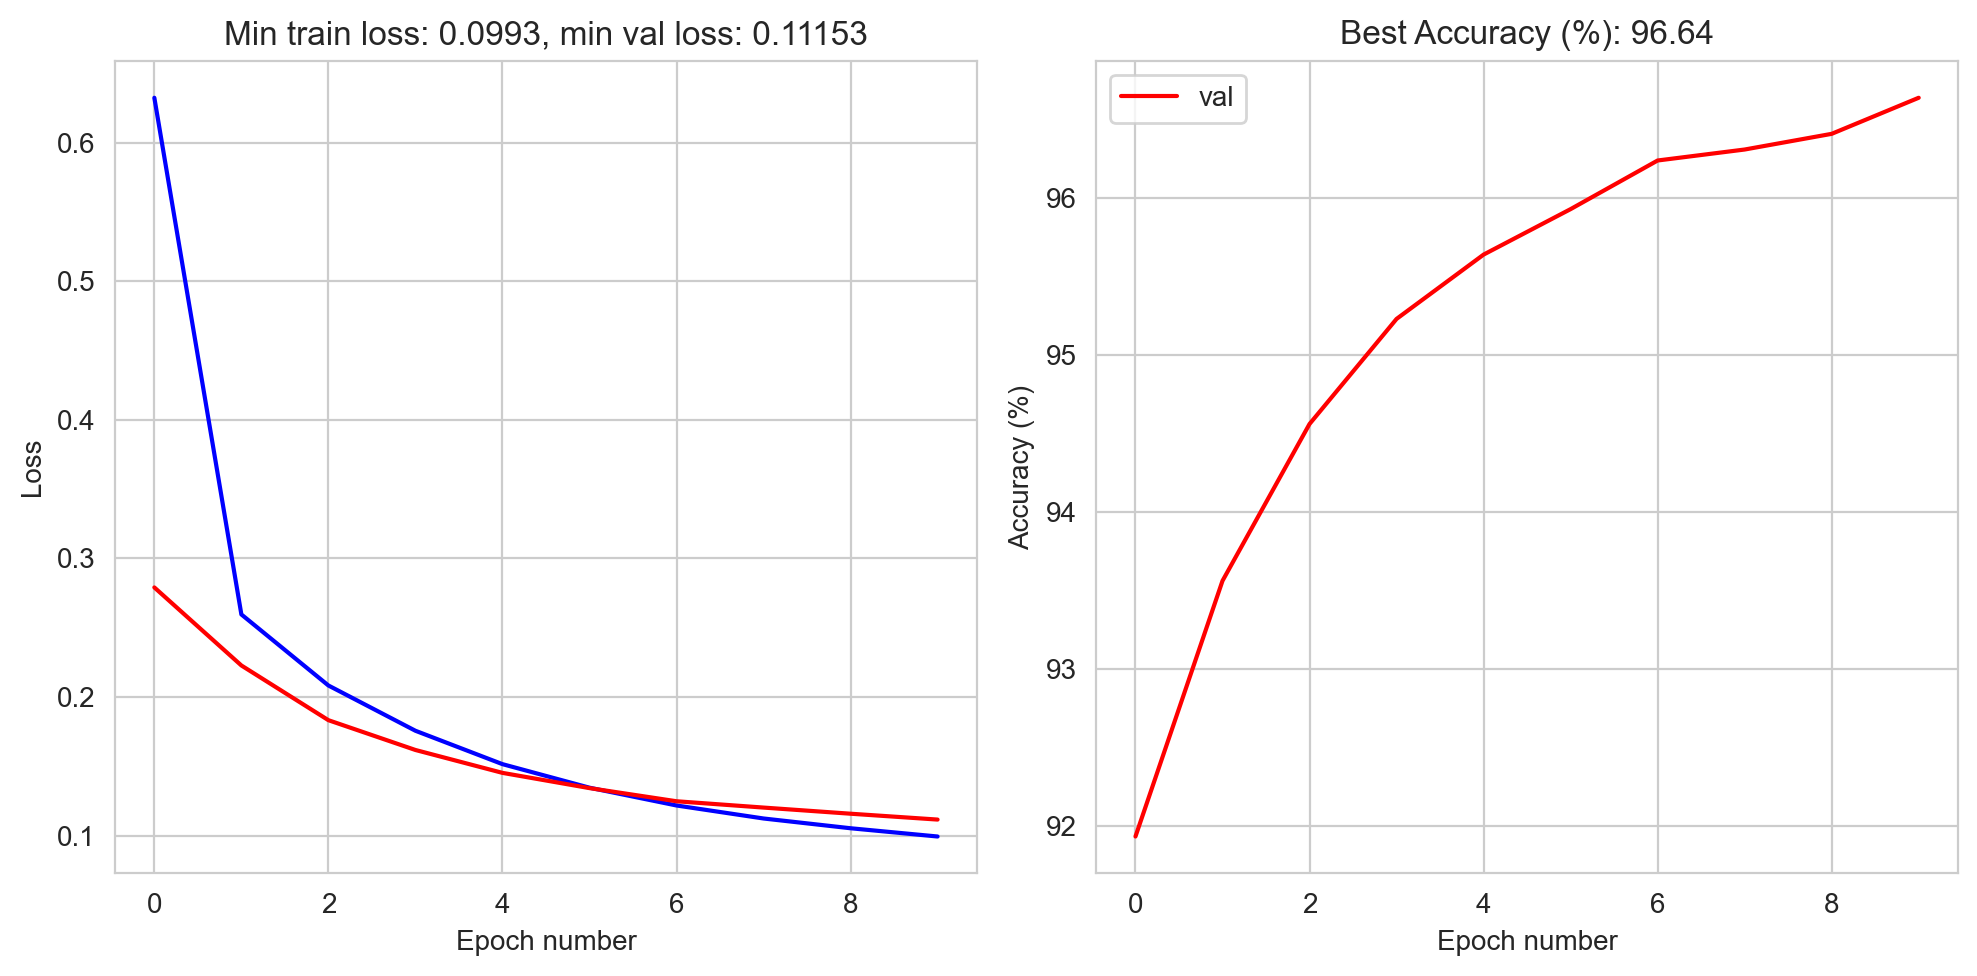

In [40]:
train(fc_net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, NUM_EPOCHS)

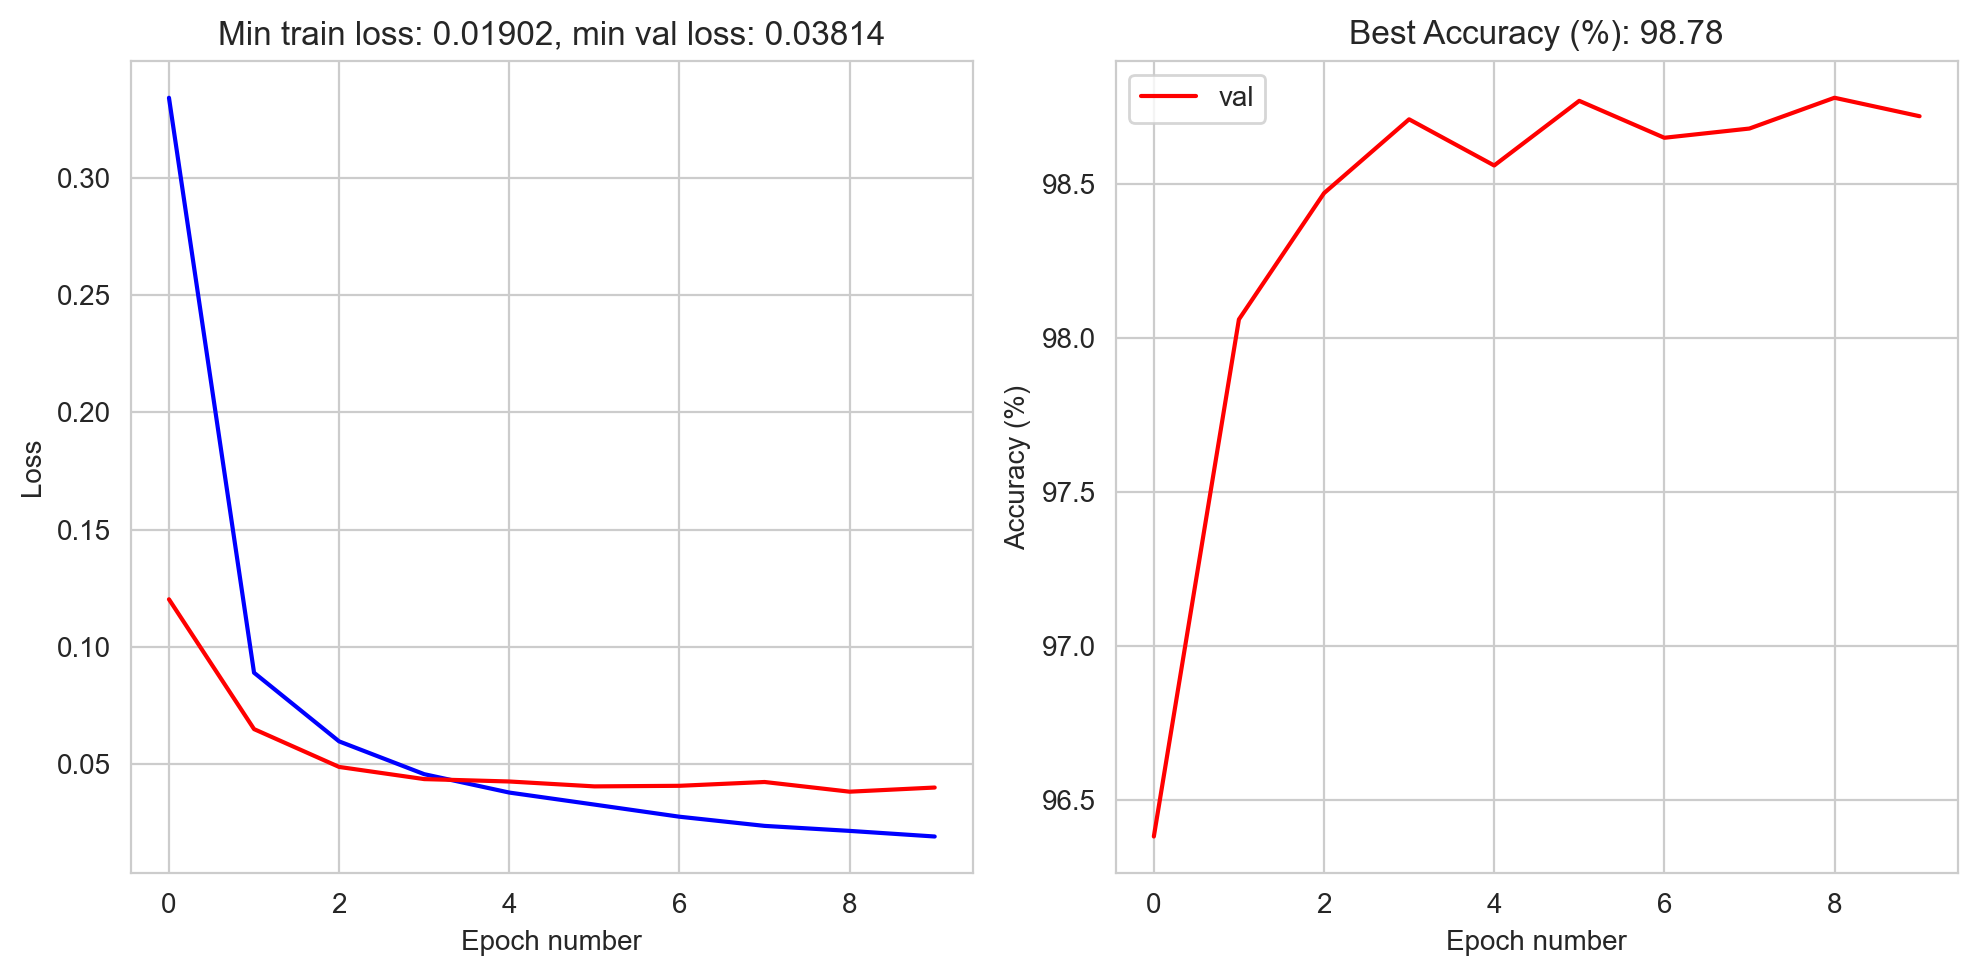

In [41]:
# Conv net

# do not forget to put the model itself on device
conv_net = ConvNetwork(1, 32, 10, image_sizes=example_img.shape[1:]) # 10 labels
conv_net.to(device)

optimizer = torch.optim.Adam(conv_net.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS * len(train_dataloader), eta_min=1e-4)
train(conv_net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, NUM_EPOCHS)

In [42]:
# Res net

# do not forget to put the model itself on device
res_net = ResNetwork(1, 32, 10, image_sizes=example_img.shape[1:]) # 10 labels
res_net.to(device)

optimizer = torch.optim.Adam(res_net.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS * len(train_dataloader), eta_min=1e-4)

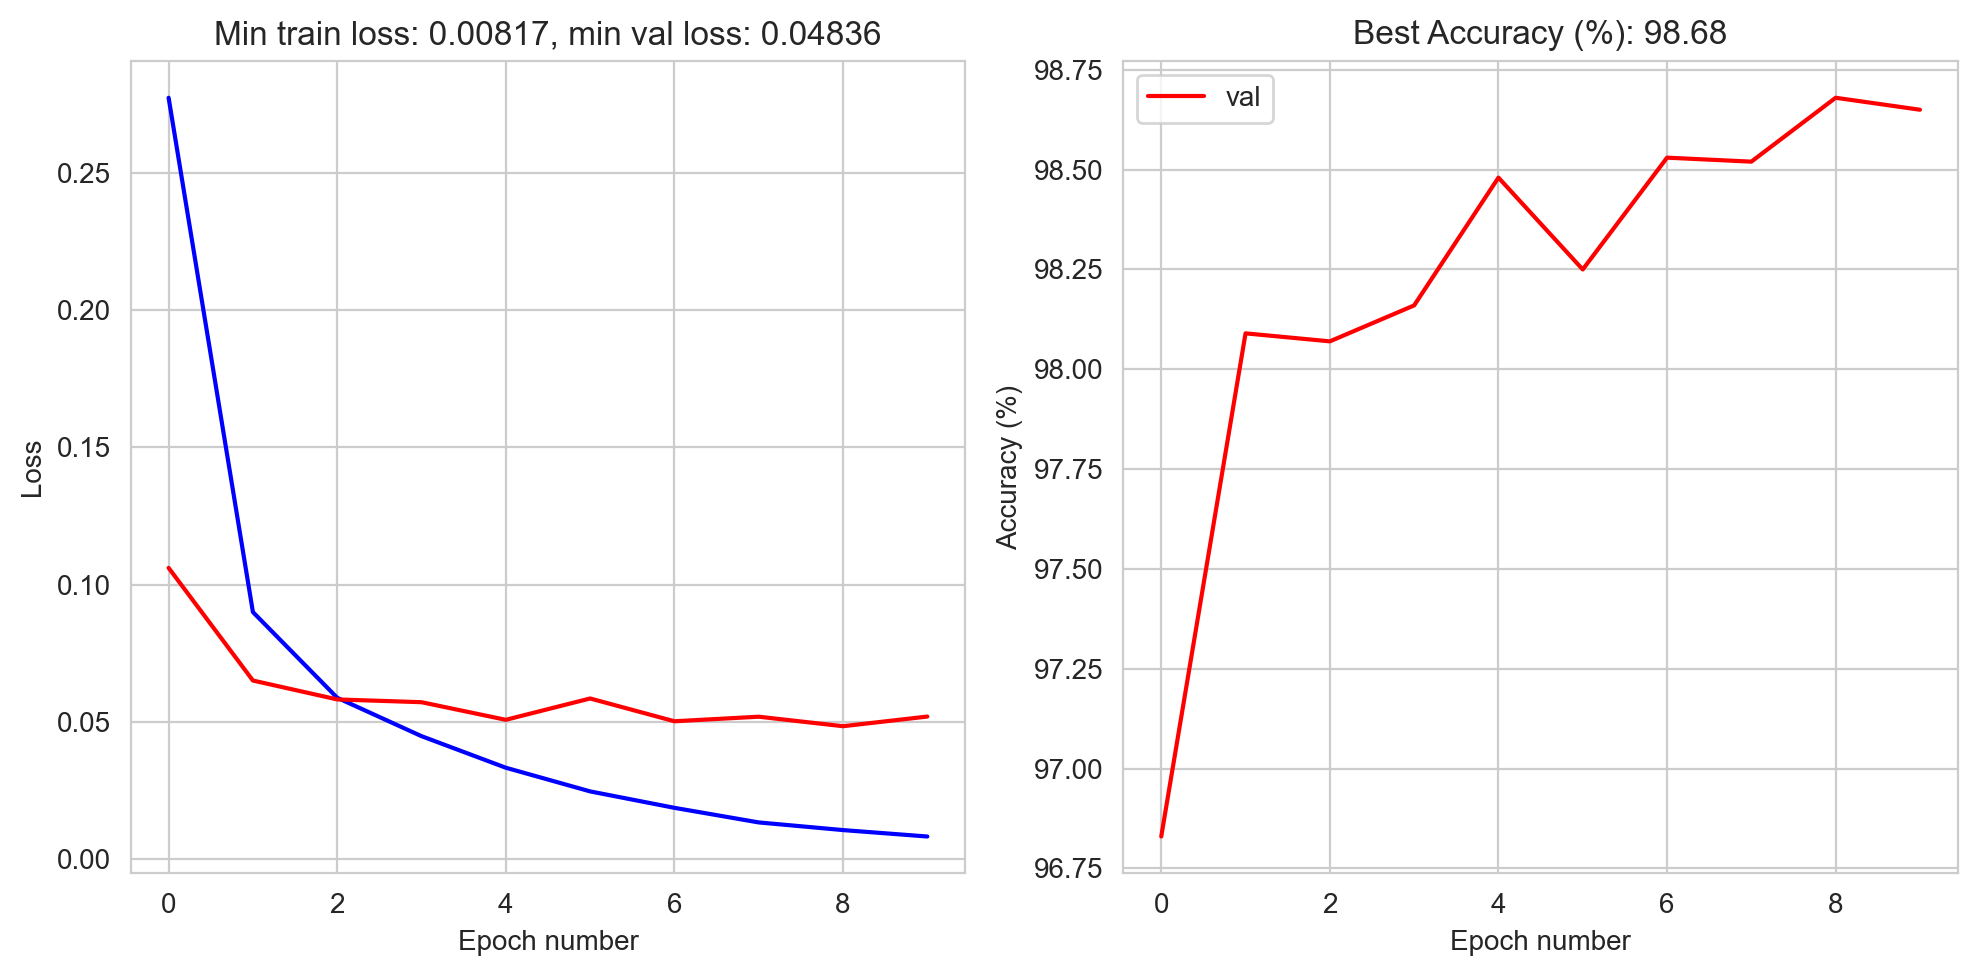

In [43]:
train(res_net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, NUM_EPOCHS)